In [1]:
# Here I want to see the firm-level correlate of France getting RCA>1 in some product

# Load modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## RCA and diversification

In [3]:

# French firms dataset
drive_path = './../../../../media/miglesia/Elements'
path1 = drive_path+'/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

firms_france_value = pd.read_csv(path1+'/samplings/large_firm_sample_YMmxp_09_13.csv') #09 to 12
firms_france_value = firms_france_value.groupby(['CN ID 8', 'ID', 'IMPORT'])[['VART_sum']].sum().reset_index()
# firms_france_value['HS ID HS4'] = firms_france_value['CN ID 8'].astype(str).str.zfill(8).str[:4].astype(int)
# FRA_firm_val_exp = firms_france_value.loc[firms_france_value.IMPORT == 0].groupby(['ID', 'HS ID HS4']).sum()[['VART_sum']].unstack()['VART_sum']
# FRA_firm_val_imp = firms_france_value.loc[firms_france_value.IMPORT == 1].groupby(['ID', 'HS ID HS4']).sum()[['VART_sum']].unstack()['VART_sum']

# firms_france_count = pd.read_csv(path1+'/samplings/firm_sample_YMmxp_09_13.csv')
# firms_france_count = firms_france_count.groupby(['CN ID 8', 'ID', 'IMPORT'])[['VART_sum']].sum().reset_index()
# firms_france_count['HS ID HS4'] = firms_france_count['CN ID 8'].astype(str).str.zfill(8).str[:4].astype(int)
# FRA_firm_cnt_exp = firms_france_count.loc[firms_france_count.IMPORT == 0].groupby(['ID', 'HS ID HS4']).sum()[['VART_sum']].unstack()['VART_sum']
# FRA_firm_cnt_imp = firms_france_count.loc[firms_france_count.IMPORT == 1].groupby(['ID', 'HS ID HS4']).sum()[['VART_sum']].unstack()['VART_sum']

wt = pd.read_csv('./wt_dest').rename({'ccode': 'ID', 'pcode': 'HS ID 4'}, axis = 1)
wt = wt.loc[wt.year.isin(range(1997, 2014))].groupby(['ID', 'HS ID 4'])[['export_val', 'import_val']].sum()
world_exports = wt.unstack()['export_val']
world_imports = wt.unstack()['import_val']

# # Load info
path = './../compute-corr-structures/data/disagg_struct_refs/formatted/'

HS = pd.read_csv(path+'hs_full.csv').astype(str)
HS[[col for col in HS.columns if 'HS ID' in col]] = HS[[col for col in HS.columns if 'HS ID' in col]].astype('float64')


In [4]:
def log10(table):
    # take logs
    return np.log10(table).replace(-np.inf, np.nan)
    
def RCA(table, bin = False):
    RCA = table.div(table.sum()).div(table.sum(axis = 1)/table.sum(axis = 1).sum(), axis = 0)
    if bin:
        RCA = (RCA > 1).astype(int)
    return RCA

def similarity_angle(df):
    row_norms = np.sqrt(np.square(df).sum()).values
    outer_values = np.outer(row_norms, row_norms)
    norm = pd.DataFrame(outer_values, columns=df.columns, index = df.columns)

    matrix_dot = df.fillna(0).T.dot(df.fillna(0))
    matrix_angle = matrix_dot.div(norm)
    return matrix_angle

def proximity(df):
    l = len(df.sum().values)
    product_ubiquity = np.asarray([df.sum().values] * l).reshape(l,-1)
    outer_values = np.maximum(product_ubiquity, product_ubiquity.T)
    norm = pd.DataFrame(outer_values, columns=df.columns, index = df.columns)

    matrix_dot = df.fillna(0).T.dot(df.fillna(0))
    matrix_proximity = matrix_dot.div(norm)
    return matrix_proximity

In [5]:
wt_ = pd.read_csv('./wt.csv')
RCA_table_list = []
for y in wt_.year.unique():
    RCA_ = RCA(wt_.loc[wt_.year == y].set_index(['ccode', 'pcode'])[['x']].rename({'x': y}, axis = 1).unstack())
    RCA_table_list += [RCA_]
    
    
RCA_table = pd.concat(RCA_table_list, axis = 1)

In [6]:
wt_['xcp'] = np.log10(wt_['x'])
wt_['Tw'] = np.log10(wt_['x'].groupby(wt_['year']).transform('sum'))
wt_['Tc'] = np.log10(wt_.groupby(['year','ccode'])['x'].transform('sum'))
wt_['Tp'] = np.log10(wt_.groupby(['year','pcode'])['x'].transform('sum'))


In [7]:
RCA_bin = (RCA_table > 1).astype(int)
RCA_bin_df = pd.DataFrame(RCA_bin.unstack().reorder_levels([1, 2, 0]).sort_index().reset_index())
RCA_bin_df.columns = ['pcode', 'ccode', 'year', 'RCA_bin']
RCA_bin_df = RCA_bin_df.merge(wt_[['pcode', 'ccode', 'year', 'xcp', 'Tc', 'Tp', 'Tw']], on = ['pcode', 'ccode', 'year'])

RCA_bin_diff = RCA_bin_df
RCA_bin_diff.iloc[:, 3:] = RCA_bin_df.iloc[:, 3:].diff().loc[RCA_bin_df.year > 2003]


In [8]:
RCA_bin_diff_fra = RCA_bin_diff.loc[RCA_bin_diff.ccode == 'fra']

RCA_bin_diff_fra_T = RCA_bin_diff_fra

period_shift_fra = RCA_bin_diff_fra_T.groupby('pcode').sum()[['RCA_bin', 'xcp', 'Tc', 'Tp', 'Tw']]
up_prods_fra = period_shift_fra.loc[period_shift_fra.RCA_bin == 1]
dn_prods_fra = period_shift_fra.loc[period_shift_fra.RCA_bin == -1]

In [11]:
up_prods_fra_sample = up_prods_fra.sample(20).sort_values(by = 'xcp').reset_index().merge(HS[['HS ID HS4', 'HS label HS4']].drop_duplicates(), left_on = 'pcode', right_on = 'HS ID HS4')
up_prods_fra_sample.style.bar(subset=['xcp', 'Tp',], align='mid', color=['#d65f5f', '#5fba7d'])

,pcode,RCA_bin,xcp,Tc,Tp,Tw,HS ID HS4,HS label HS4
0,3706,1,-0.808301,0.203085,-1.13178,0.378463,3706,"3706 - Cinematographic film; exposed and developed, whether or not incorporating sound track or consisting only of sound track"
1,8540,1,-0.202866,0.203085,-0.811593,0.378463,8540,"8540 - Thermionic, cold cathode or photo-cathode valves and tubes (e.g. vacuum, vapour, gas filled valves and tubes, mercury arc rectifying valves and tubes, cathode-ray and television camera tubes)"
2,2939,1,0.150113,0.203085,0.122727,0.378463,2939,"2939 - Alkaloids, vegetable; natural or reproduced by synthesis, and their salts, ethers, esters and other derivatives"
3,8418,1,0.217253,0.203085,0.331751,0.378463,8418,"8418 - Refrigerators, freezers and other refrigerating or freezing equipment, electric or other; heat pumps other than air conditioning machines of heading no. 8415"
4,2907,1,0.296726,0.203085,0.286992,0.378463,2907,"2907 - Phenols; monophenols, polyphenols, and phenol-alcohols"
5,1515,1,0.404929,0.203085,0.369793,0.378463,1515,"1515 - Fixed vegetable fats and oils (including jojoba oil) and their fractions, whether or not refined; but not chemically modified"
6,3815,1,0.408161,0.203085,0.475487,0.378463,3815,"3815 - Reaction initiators, reaction accelerators and catalytic preparations n.e.c. or included"
7,3211,1,0.42262,0.203085,0.343671,0.378463,3211,3211 - Driers; prepared
8,4812,1,0.42411,0.203085,0.252961,0.378463,4812,"4812 - Filter blocks, slabs and plates of paper pulp"
9,8537,1,0.440841,0.203085,0.567776,0.378463,8537,"8537 - Boards, panels, consoles, desks, cabinets, bases with apparatus of heading no. 8535, 8536 for electricity control and distribution, (other than switching apparatus of heading no. 8517)"


In [14]:
dn_prods_fra_sample = dn_prods_fra.sample(20).sort_values(by = 'xcp').reset_index().merge(HS[['HS ID HS4', 'HS label HS4']].drop_duplicates(), left_on = 'pcode', right_on = 'HS ID HS4')
dn_prods_fra_sample.style.bar(subset=['xcp', 'Tp',], align='mid', color=['#d65f5f', '#5fba7d'])

,pcode,RCA_bin,xcp,Tc,Tp,Tw,HS ID HS4,HS label HS4
0,5105,-1,-1.7518,0.203085,0.0642652,0.378463,5105,5105 - Wool and fine or coarse animal hair; carded or combed (including combed wool in fragments)
1,5210,-1,-0.660874,0.203085,0.048102,0.378463,5210,"5210 - Woven fabrics of cotton, containing less than 85% by weight of cotton, mixed mainly or solely with man-made fibres, weighing not more than 200 g/m2"
2,2927,-1,-0.594927,0.203085,0.283517,0.378463,2927,"2927 - Diazo-, azo- or azoxy-compounds"
3,5516,-1,-0.332466,0.203085,0.128776,0.378463,5516,5516 - Woven fabrics of artificial staple fibres
4,7316,-1,-0.304885,0.203085,0.460269,0.378463,7316,"7316 - Anchors, grapnels and parts thereof, of iron or steel"
5,3204,-1,-0.260195,0.203085,0.126178,0.378463,3204,3204 - Synthetic organic colouring matter and preparations based thereon; synthetic organic products used as fluorescent brightening agents or as luminophores; whether or not chemically defined
6,2715,-1,-0.210363,0.203085,0.958415,0.378463,2715,"2715 - Bituminous mixtures based on natural asphalt; on natural bitumen, on petroleum bitumen, on mineral tar or on mineral tar pitch (e.g. bituminous mastics, cut-backs)"
7,5903,-1,-0.12338,0.203085,0.279365,0.378463,5903,"5903 - Textile fabrics impregnated, coated, covered or laminated with plastics, other than those of heading no. 5902"
8,5511,-1,-0.115415,0.203085,0.389593,0.378463,5511,"5511 - Yarn (not sewing thread), of man-made staple fibres, put up for retail sale"
9,8455,-1,-0.103599,0.203085,0.297459,0.378463,8455,8455 - Metal-rolling mills and rolls therefor


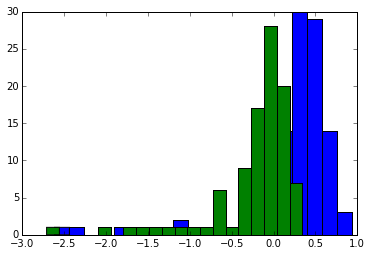

In [51]:
# dn_prods_fra

plt.hist(up_prods_fra['xcp'].values, 20)
plt.hist(dn_prods_fra['xcp'].values, 20)
plt.show()

(6, 10)

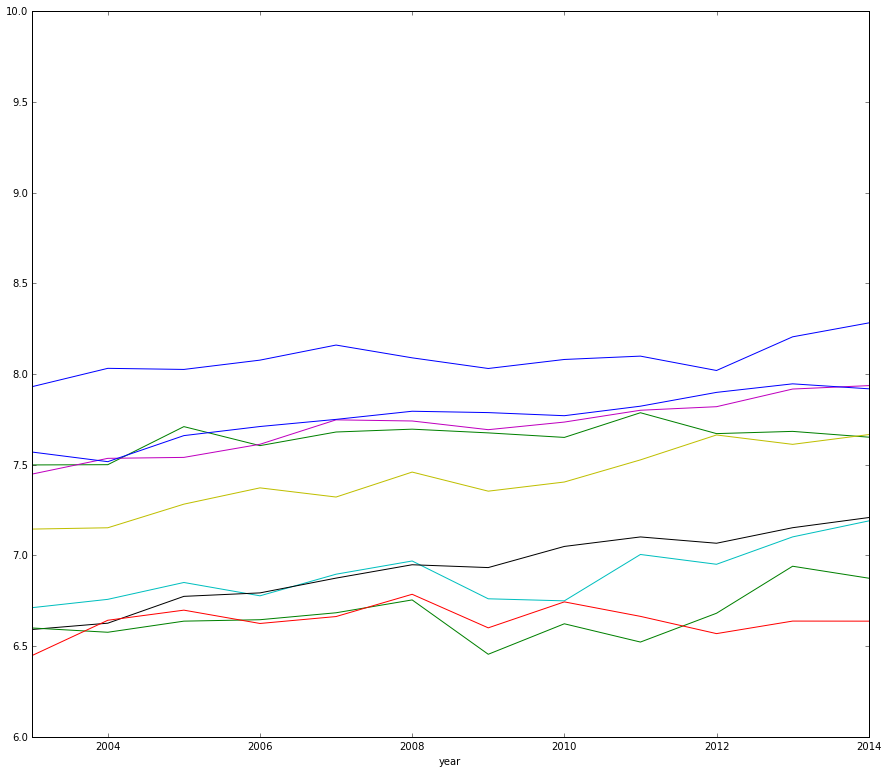

In [29]:
up_prods_ts_log = np.log10(wt_.loc[wt_.ccode == 'fra'].loc[wt_.pcode.isin(up_prods_fra.index[:10])].groupby(['pcode', 'year']).first()[['x']])
# up_prods_ts_log = np.log10(wt_.loc[wt_.ccode == 'fra'].loc[wt_.pcode.isin(dn_prods_fra.index)].groupby(['pcode', 'year']).first()[['x']])

fig, ax = plt.subplots(1, figsize = (15, 13))
up_prods_ts_log.unstack(0).plot(legend = False, ax = ax)
ax.set_ylim(6, 10)

## Firm level data

In [ ]:
# French firms dataset
# drive_path = './../../../../media/miglesia/Elements'
# path1 = drive_path+'/export_france/data/type1/DP1610_MAASTRICHT1_1997_2013'

firms_france_value = pd.read_csv(path1+'/samplings/large_firm_sample_YMmxp_03_13.csv') #09 to 12
firms_france_value = firms_france_value.groupby(['YEAR', 'MONTH', 'CN ID 8', 'IMPORT'])[['VART_sum']].sum().reset_index()
firms_france_value['HS ID HS4'] = firms_france_value['CN ID 8'].astype(str).str.zfill(8).str[:4].astype(int)


In [34]:
df = firms_france_value

df_table = df.loc[df.IMPORT == 0].groupby(['YEAR', 'MONTH', 'HS ID HS4'])[['VART_sum']].sum().unstack()
df_table_ = df_table.reset_index()
df_table_['DAY'] = 1
df_table_['date'] = pd.to_datetime(df_table_.YEAR*10000+df_table_.MONTH*100+df_table_.DAY,format='%Y%m%d')
df_table_ = df_table_.set_index('date', drop = True)
HS4_time = df_table_[df_table.columns]
# CN8_time = df_table_[df_table.columns]

(2003, 2013)

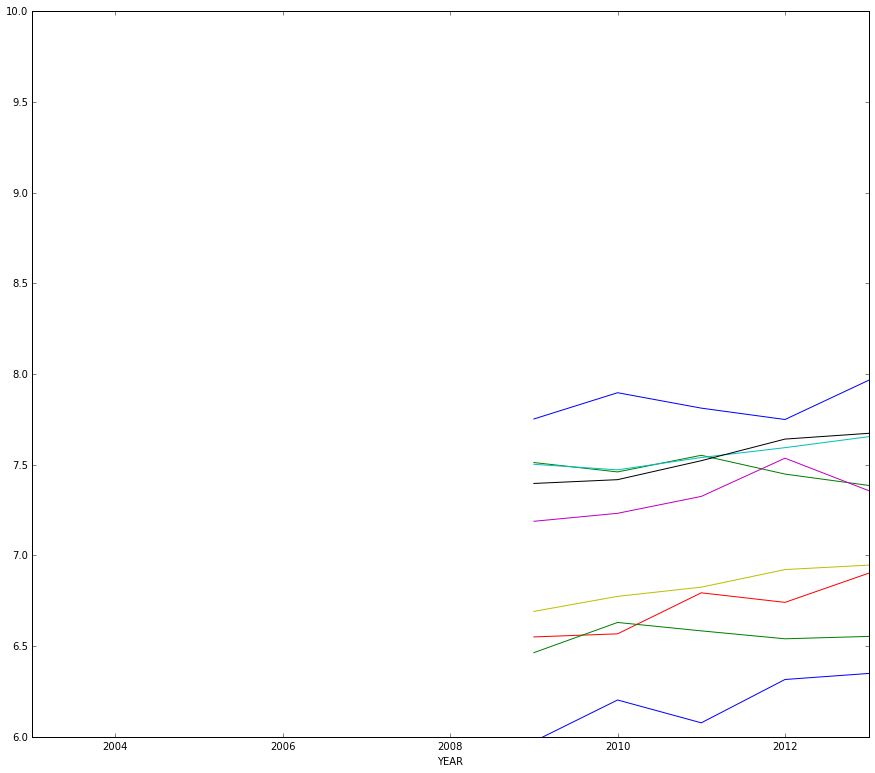

In [30]:
df = firms_france_value
firms_up_prods = df.loc[df['HS ID HS4'].isin(up_prods_fra.index) & (df.IMPORT == 0)]

firms_up_prods_ts_log = np.log10(firms_up_prods.groupby(['HS ID HS4', 'YEAR'])[['VART_sum']].sum())

fig, ax = plt.subplots(1, figsize = (15, 13))
firms_up_prods_ts_log.unstack(0).plot(legend = False, ax = ax)
ax.set_ylim(6, 10)
ax.set_xlim(2003, 2013)

In [52]:
firms_france_value_id = firms_france_value.groupby(['YEAR', 'MONTH', 'CN ID 8', 'ID','IMPORT'])[['VART_sum']].sum().reset_index()
df = firms_france_value
i = 0
# df.loc[(df.IMPORT == 0) & (df['HS ID HS4'] == up_prods_fra.index[i])][['VART_sum']]#.sum()
firms_france_value

,YEAR,MONTH,CN ID 8,IMPORT,VART_sum,HS ID HS4
0,2009,1,1011010,0,1797434,101
1,2009,1,1011010,1,1732014,101
2,2009,1,1019011,0,187953,101
3,2009,1,1019011,1,189044,101
4,2009,1,1019019,0,826839,101
5,2009,1,1019019,1,5361191,101
6,2009,1,1019030,1,2946,101
7,2009,1,1021010,0,346444,102
8,2009,1,1021010,1,62934,102
9,2009,1,1021030,0,191966,102
